# Dense Optical Tracking

# Setting

In [1]:
!git clone https://github.com/snu-rvl/dot.git

Cloning into 'dot'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 177 (delta 18), reused 174 (delta 18), pack-reused 0
Receiving objects: 100% (177/177), 2.71 MiB | 36.58 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
!cd ./dot && mkdir -p checkpoints \
&& cd checkpoints \
&& wget https://huggingface.co/16lemoing/dot/resolve/main/movi_f_cotracker2_patch_4_wind_8.pth \
&& wget https://huggingface.co/16lemoing/dot/resolve/main/cvo_raft_patch_8.pth \
&& wget https://huggingface.co/16lemoing/dot/resolve/main/movi_f_raft_patch_4_alpha.pth

--2024-08-12 16:03:53--  https://huggingface.co/16lemoing/dot/resolve/main/movi_f_cotracker2_patch_4_wind_8.pth
Resolving huggingface.co (huggingface.co)... 13.225.131.94, 13.225.131.93, 13.225.131.35, ...
Connecting to huggingface.co (huggingface.co)|13.225.131.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/40/5f/405f8301e85c5bbb03ff713231b36987b41e7020e9e5bbcf643f155092c8e084/89e7585d3e95d6e2bc4ff74ce072a98f70377047e669d44fa0b5c01311d4f54c?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27movi_f_cotracker2_patch_4_wind_8.pth%3B+filename%3D%22movi_f_cotracker2_patch_4_wind_8.pth%22%3B&Expires=1723705433&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMzcwNTQzM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQwLzVmLzQwNWY4MzAxZTg1YzViYmIwM2ZmNzEzMjMxYjM2OTg3YjQxZTcwMjBlOWU1YmJjZjY0M2YxNTUwOTJjOGUwODQvODllNzU4NWQzZTk1ZDZlMmJjNGZm

In [3]:
!pip install torch==2.0.1 torchvision==0.15.2
!pip install tensorboard
!pip install tqdm matplotlib einops einshape scipy timm lmdb av mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.5 MB/s eta 0:00:00


In [5]:
!wget -P datasets https://huggingface.co/16lemoing/dot/resolve/main/demo.zip
!unzip datasets/demo.zip -d datasets/

--2024-08-12 16:06:03--  https://huggingface.co/16lemoing/dot/resolve/main/demo.zip
Resolving huggingface.co (huggingface.co)... 13.225.131.93, 13.225.131.35, 13.225.131.94, ...
Connecting to huggingface.co (huggingface.co)|13.225.131.93|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/40/5f/405f8301e85c5bbb03ff713231b36987b41e7020e9e5bbcf643f155092c8e084/aaf9aacf88cc31037f8575394c585fe2f039e000cb612a5218851e064a72d875?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27demo.zip%3B+filename%3D%22demo.zip%22%3B&response-content-type=application%2Fzip&Expires=1723705563&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMzcwNTU2M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQwLzVmLzQwNWY4MzAxZTg1YzViYmIwM2ZmNzEzMjMxYjM2OTg3YjQxZTcwMjBlOWU1YmJjZjY0M2YxNTUwOTJjOGUwODQvYWFmOWFhY2Y4OGNjMzEwMzdmODU3NTM5NGM1ODVmZTJmMDM5ZTAwMGNiNjEyYTUyMTg4NTFl

# Explanation about detailed architecture of DOT


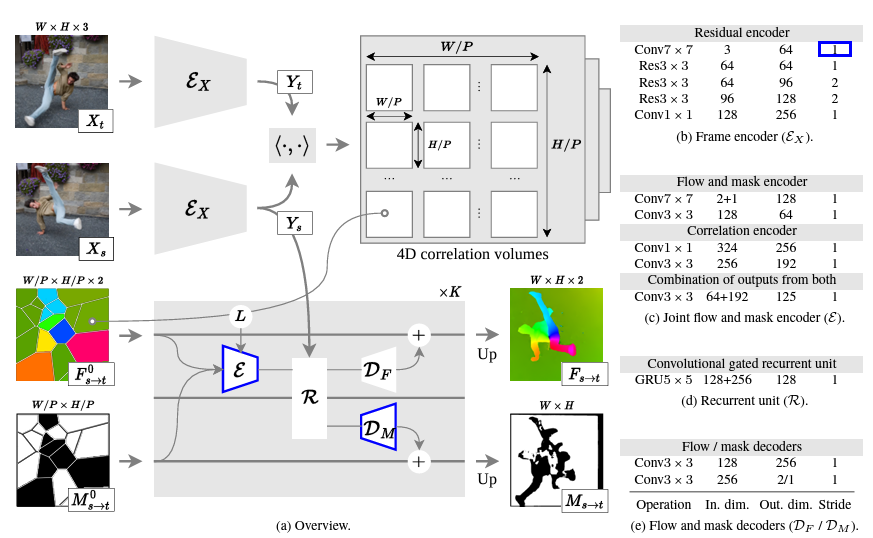


## 구성 요소
1. Initial point tracking (CoTracker 이용)
2. Initialization of approximate flow field and visibility mask(nearest neighbor interpolation 이용)
3. Optical flow refinement(RAFT 이용)

#### (참고) RAFT와 다른 점.
1. 첫번째 convolution layer에서 stride를 1로 사용해 resolution이 p=4로 감소
2. visibility mask도 함께 예측함. 인코더 ϵ을 수정하고, 새로운 modality를 고려하기 위해 새로운 디코더 $D_M$을 추가

# Code Implementation


## 1. PointTracker 클래스 내부에 주요 함수 구현
### 1) PointTracker 클래스 설명
get_tracks_at_motion_boundaries와 get_flow_from_last_to_first_frame이 두 가지 주요 작업을 합니다. 각각 다른 방식으로 비디오 내의 포인트들을 추적하고 다른 목적을 위해 데이터를 생성합니다.
- get_tracks_at_motion_boundaries: 비디오의 프레임 간의 motion boundaries를 추출하고, 해당 boundary 위의 point들을 추적하여 tracking 데이터를 생성합니다.
- get_flow_from_last_to_first_frame: 비디오의 마지막 프레임에서 첫 번째 프레임까지의 Optical Flow를 계산합니다. 이를 통해 비디오 내의 전체 움직임 경로를 파악할 수 있습니다.

### 1) get_tracks_at_motion_boundaries
- 함수 인자 설명
  - data: dictionary 형태로, video라는 키가 있어 비디오 데이터를 담고 있습니다. 비디오는 텐서 형식으로 B, T, C, H, W 차원을 가집니다.
  - num_tracks: 추저할 총 포인트의 수를 의미합니다. 기본 값으로 8192를 가집니다.
  - sim_tracks: 샘플링하여 추적할 포인트의 수를 의미합니다. 기본 값으로 2048을 가집니다. 한 번에 추적할 포인트 수를 조절해서 연산의 효율성을 높일 수 있습니다.
  - sample_mode : 포인트를 샘플링할 모드를 지정합니다. all, first, last 중에 choice 가능합니다.

- TODO:
샘플링 모드에 따라 샘플링 방식을 주석을 참고하여 코드를 구현해보세요.

### 1) get_flow_from_last_to_first_frame
- 함수 설명
비디오의 마지막 프레임에서 첫 번째 프레임으로의 optical flow나 tracking을 계산하는 역할을 합니다. 주어진 비디오를 시간 축을 따라 뒤집어, 마지막 프레임을 첫 번째 프레임으로 간주하여 계산을 진행합니다. \\

- 함수 인자 설명
  - data: dictionary 형태로, video라는 키가 있어 비디오 데이터를 담고 있습니다. 비디오는 텐서 형식으로 B, T, C, H, W 차원을 가집니다.
  - sim_tracks: 샘플링하여 추적할 포인트의 수를 의미합니다. 기본 값으로 2048을 가집니다. 한 번에 추적할 포인트 수를 조절해서 연산의 효율성을 높일 수 있습니다.

- TODO:
트랙킹을 위해 비디오 내의 특정 포인트를 샘플링하고, 모델이 포인트들의 트래킹 경로와 가시성(visibility)을 계산한 뒤, 이를 바탕으로 플로우 맵을 업데이트하는 방식을 사용합니다.
주석을 참고하여 코드를 구현해보세요.

In [2]:
from tqdm import tqdm
import torch
from torch import nn

from dot.dot.models.shelf import CoTracker, CoTracker2, Tapir
from dot.dot.utils.io import read_config
from dot.dot.utils.torch import sample_points, sample_mask_points, get_grid


class PointTracker(nn.Module):
    def __init__(self,  height, width, tracker_config, tracker_path, estimator_config, estimator_path):
        super().__init__()
        model_args = read_config(tracker_config)
        model_dict = {
            "cotracker": CoTracker,
            "cotracker2": CoTracker2,
            "tapir": Tapir,
            "bootstapir": Tapir
        }
        self.name = model_args.name
        self.model = model_dict[model_args.name](model_args)
        if tracker_path is not None:
            device = next(self.model.parameters()).device
            self.model.load_state_dict(torch.load(tracker_path, map_location=device), strict=False)
        self.optical_flow_estimator = OpticalFlow(height, width, estimator_config, estimator_path)

    def forward(self, data, mode, **kwargs):
        if mode == "tracks_at_motion_boundaries":
            return self.get_tracks_at_motion_boundaries(data, **kwargs)
        elif mode == "flow_from_last_to_first_frame":
            return self.get_flow_from_last_to_first_frame(data, **kwargs)
        else:
            raise ValueError(f"Unknown mode {mode}")

    def get_tracks_at_motion_boundaries(self, data, num_tracks=8192, sim_tracks=2048, sample_mode="all", **kwargs):
        video = data["video"]
        N, S = num_tracks, sim_tracks
        B, T, _, H, W = video.shape
        assert N % S == 0

        # [TODO] Define sampling strategy
        '''
          "all" 모드: 모든 프레임에서 균등하게 포인트를 샘플링합니다.
          "first" 모드: 첫 번째 프레임에서만 포인트를 샘플링합니다.
          "last" 모드: 마지막 프레임에서만 포인트를 샘플링합니다.
        '''
        if sample_mode == "all":
            # Implement here
            samples_per_step = [S // T for _ in range(T)]
            samples_per_step[0] += S - sum(samples_per_step)
            backward_tracking = True
            flip = False
        elif sample_mode == "first":
            # Implement here
            samples_per_step = [0 for _ in range(T)]
            samples_per_step[0] += S
            backward_tracking = False
            flip = False
        elif sample_mode == "last":
            # Implement here
            samples_per_step = [0 for _ in range(T)]
            samples_per_step[0] += S
            backward_tracking = False
            flip = True
        else:
            raise ValueError(f"Unknown sample mode {sample_mode}")

        if flip:
            video = video.flip(dims=[1])

        # Track batches of points
        tracks = []
        motion_boundaries = {}
        cache_features = True
        for _ in tqdm(range(N // S), desc="Track batch of points", leave=False):
            src_points = []
            for src_step, src_samples in enumerate(samples_per_step):
                if src_samples == 0:
                    continue
                if not src_step in motion_boundaries:
                    tgt_step = src_step - 1 if src_step > 0 else src_step + 1
                    data = {"src_frame": video[:, src_step], "tgt_frame": video[:, tgt_step]}
                    pred = self.optical_flow_estimator(data, mode="motion_boundaries", **kwargs)
                    motion_boundaries[src_step] = pred["motion_boundaries"]
                src_boundaries = motion_boundaries[src_step]
                src_points.append(sample_points(src_step, src_boundaries, src_samples))
            src_points = torch.cat(src_points, dim=1)
            traj, vis = self.model(video, src_points, backward_tracking, cache_features)
            tracks.append(torch.cat([traj, vis[..., None]], dim=-1))
            cache_features = False
        tracks = torch.cat(tracks, dim=2)

        if flip:
            tracks = tracks.flip(dims=[1])

        return {"tracks": tracks}

    def get_flow_from_last_to_first_frame(self, data, sim_tracks=2048, **kwargs):
        video = data["video"]
        video = video.flip(dims=[1])
        src_step = 0  # We have flipped video over temporal axis so src_step is 0
        B, T, C, H, W = video.shape
        S = sim_tracks
        backward_tracking = False
        cache_features = True
        flow = get_grid(H, W, shape=[B]).cuda()   # 초기 flow map 생성
        flow[..., 0] = flow[..., 0] * (W - 1)
        flow[..., 1] = flow[..., 1] * (H - 1)
        alpha = torch.zeros(B, H, W).cuda()       # visibility 저장할 텐서 초기화
        mask = torch.ones(H, W)                   # 전체 영역 1로 초기화
        pbar = tqdm(total=H * W // S, desc="Track batch of points", leave=False)
        while torch.any(mask):
            points, (i, j) = sample_mask_points(src_step, mask, S)
            idx = i * W + j
            points = points.cuda()[None].expand(B, -1, -1)

            traj, vis = self.model(video, points, backward_tracking, cache_features)
            traj = traj[:, -1]
            vis = vis[:, -1].float()

            # [TODO2] mask, flow map, visibility map(alpha) update
            '''
              Update mask
              포인트들이 추적되었으므로, 마스크에서 포인트들을 0으로 바꿔주어야 합니다.
            '''
            mask = mask.view(-1)
            # Implement here [1 line]
            mask[idx] = 0
            mask = mask.view(H, W)
            '''
              Update flow
              포인트들의 이동 경로에 따라 flow map을 모델에서 추론한 trajectory(traj)를 이용하여 업데이트 해야 합니다.
              hint: traj에서 flow를 인덱스에 맞춰 빼주면 됩니다.
            '''
            flow = flow.view(B, -1, 2)
            # Implement here [1 line]
            flow[:, idx] = traj - flow[:, idx]
            flow = flow.view(B, H, W, 2)

            '''
              Update visibility map (alpha)
              point 들의 visibility를 모델에서 추론한 visibility(vis)를 이용하여 인덱스에 맞춰 업데이트 해야 합니다.
            '''
            alpha = alpha.view(B, -1)
            # Implement here [1 line]
            alpha[:, idx] = vis
            alpha = alpha.view(B, H, W)

            cache_features = False
            pbar.update(1)
        pbar.close()
        return {"flow": flow, "alpha": alpha}


## 2. OpticalFlow 클래스 내부의 주요 함수 구현

### 1) OpticalFlow 클래스 설명
이 클래스는 RAFT와 같은 모델을 사용해 비디오 프레임 간의 움직임을 계산하고, 여러 가지 모드에 따라 다양한 기능을 제공합니다. 클래스는 다양한 모드의 전처리, 추출, 및 분석 작업을 수행하는 메서드들을 포함하고 있습니다
- get_flow_with_tracks_init: 초기화된 포인트에 대한 optical flow를 계산합니다. 추정된 coarse flow와 alpha 값을 기반으로 더 정밀한 optical flow를 계산하며, visibility map(alpha)도 함께 반환합니다.
- get_motion_boundaries: DOT 모델에서 주어진 source frame('src_frame')과 target frame('tgt_frame')사이의 motion boundary를 계산하는 역할을 합니다. 두 프레임 간의 optical flow를 계산하고, sobel filter를 사용해 boundary를 찾은 후, motion_boundaries와 flow 데이터를 반환 합니다.

### 1) get_flow_with_tracks_init에서 사용할 interpolate 함수 구현
- 구현 함수 설명: 소스 포인트(src_points)와 타겟 포인트(tgt_points) 간의 상관관계를 바탕으로 옵티컬 플로우를 초기화하는 역할을 합니다. 함수는 특정 그리드 상에서 가장 가까운 소스 포인트를 찾고, 그에 대응하는 타겟 포인트의 움직임을 계산하여 flow map을 생성합니다.
- 함수 인자 설명
- src_points: source point를 포함하는 텐서, 각 포인트의 위치와 visibility를 나타냄.
- tgt_points: target point를 포함하는 텐서, 각 포인트의 위치와 visibility를 나타냄.
- grid: grid 좌표를 나타내는 텐서, grid는 source와 target point들 사이의 거리를 계산하는 데 사용됨.
- TODO: 특정 그리드 상에서 가장 가까운 소스 포인트를 찾고, 대응하는 point 움직임을 계산해보세요.


### 2) get_motion_boundaries
- 함수 인자 설명
  - data: dictionary 형태로, src_frame과 tgt_frame을 포함
  - boundaries_size: boundary를 찾기 위한 필터의 크기 정의
  - boundaries_dialiation: boundary 팽창시키는 정도 정의
  - boundaries_thresh: 최종 boundary를 판단하는 임계 값
- TODO:
sobel filter를 적용하여 boundary를 감지하는 부분을 주석을 참고하여 작성해보시면 됩니다.

  hint: 'F.conv2d'함수로 적용시켜보세요. (https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html)

#### (참고) Sobel filter
이미지나 영상에서 edge로 표현되는 곳은 픽셀의 값이 한쪽으로 급격히 변하는 부분입니다. 기본적으로 edge를 찾아내기 위해서 픽셀값의 변화율(미분)을 측정하고 변화율이 큰 픽셀을 edge라고 생각하게 됩니다. \\
픽셀 단위의 미분이므로 discrete differenation, Derivative approximation(미분 근사화)를 통해 얻어지는데, 이미지 내의 미분을 하기 위해서 여러 미분 마스크가 개발이 되었고, 그 중 하나가 sobel filter입니다. \\
이번 실습에서는 sobel filter를 구현하시지 않아도 되고 get_sobel_kernel이라는 함수를 통해 미분 마스크를 사용할 수 있습니다.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

from dot.dot.models.shelf import RAFT
from dot.dot.utils.io import read_config
from dot.dot.utils.torch import get_grid

import warnings
import torch

try:
    from dot.dot.utils import torch3d
except ModuleNotFoundError:
    torch3d = None

if torch3d:
    TORCH3D_AVAILABLE = True
else:
    TORCH3D_AVAILABLE = False


def interpolate(src_points, tgt_points, grid, version="torch3d"):
    B, S, _ = src_points.shape
    H, W, _ = grid.shape

    # For each point in a regular grid, find indices of nearest visible source point
    grid = grid.view(1, H * W, 2).expand(B, -1, -1)  # B HW 2
    src_pos, src_alpha = src_points[..., :2], src_points[..., 2]
    if version == "torch" or (version == "torch3d" and not TORCH3D_AVAILABLE):
        if version == "torch3d":
            warnings.warn(
                "Torch3D is not available. For optimal speed and memory consumption, consider setting it up.",
                stacklevel=2,
            )

        # TODO 가장 가까운 소스 포인트 찾기
        '''
        # 1) 각 그리드 포인트와 소스 포인트 간의 거리를 계산
        # 2) 가시성이 없는 포인트에 대해 거리를 무한대(inf)로 설정
        # 3) 가장 가까운 포인트의 인덱스를 찾아 줍니다.
        '''
        # Implement here
        dis = (grid ** 2).sum(-1)[:, None] + (src_pos ** 2).sum(-1)[:, :, None] - 2 * src_pos @ grid.permute(0, 2, 1)
        dis[src_alpha == 0] = float('inf')
        _, idx = dis.min(dim=1)
        idx = idx.view(B, H * W, 1)
    elif version == "torch3d":
        src_pos_packed = src_pos[src_alpha.bool()]
        tgt_points_packed = tgt_points[src_alpha.bool()]
        lengths = src_alpha.sum(dim=1).long()
        max_length = int(lengths.max())
        cum_lengths = lengths.cumsum(dim=0)
        cum_lengths = torch.cat([torch.zeros_like(cum_lengths[:1]), cum_lengths[:-1]])
        src_pos = torch3d.packed_to_padded(src_pos_packed, cum_lengths, max_length)
        tgt_points = torch3d.packed_to_padded(tgt_points_packed, cum_lengths, max_length)
        _, idx, _ = torch3d.knn_points(grid, src_pos, lengths2=lengths, return_nn=False)
        idx = idx.view(B, H * W, 1)

    # Use correspondences between source and target points to initialize the flow
    # TODO 소스와 타겟 포인트 간의 플로우 초기화
    '''
      1) 타겟 포인트에서 소스 포인트를 빼서 플로우(flow)를 계산
      2) 플로우 값을 gather 연산을 통해 정렬
    '''
    tgt_pos, tgt_alpha = tgt_points[..., :2], tgt_points[..., 2]
    # Implement here
    flow = tgt_pos - src_pos
    flow = torch.cat([flow, tgt_alpha[..., None]], dim=-1)  # B S 3
    flow = flow.gather(dim=1, index=idx.expand(-1, -1, flow.size(-1)))

    flow = flow.view(B, H, W, -1)
    flow, alpha = flow[..., :2], flow[..., 2]
    flow[..., 0] = flow[..., 0] * (W - 1)
    flow[..., 1] = flow[..., 1] * (H - 1)
    return flow, alpha

def get_sobel_kernel(kernel_size):
    K = kernel_size
    sobel = torch.tensor(list(range(K))) - K // 2
    sobel_x, sobel_y = sobel.view(-1, 1), sobel.view(1, -1)
    sum_xy = sobel_x ** 2 + sobel_y ** 2
    sum_xy[sum_xy == 0] = 1
    sobel_x, sobel_y = sobel_x / sum_xy, sobel_y / sum_xy
    sobel_kernel = torch.stack([sobel_x.unsqueeze(0), sobel_y.unsqueeze(0)], dim=0)
    return sobel_kernel

class OpticalFlow(nn.Module):
    def __init__(self, height, width, config, load_path):
        super().__init__()
        model_args = read_config(config)
        model_dict = {"raft": RAFT}
        self.model = model_dict[model_args.name](model_args)
        self.name = model_args.name
        if load_path is not None:
            device = next(self.model.parameters()).device
            self.model.load_state_dict(torch.load(load_path, map_location=device))
        coarse_height, coarse_width = height // model_args.patch_size, width // model_args.patch_size
        self.register_buffer("coarse_grid", get_grid(coarse_height, coarse_width))

    def forward(self, data, mode, **kwargs):
        if mode == "flow_with_tracks_init":
            return self.get_flow_with_tracks_init(data, **kwargs)
        elif mode == "motion_boundaries":
            return self.get_motion_boundaries(data, **kwargs)
        elif mode == "feats":
            return self.get_feats(data, **kwargs)
        elif mode == "tracks_for_queries":
            return self.get_tracks_for_queries(data, **kwargs)
        elif mode == "tracks_from_first_to_every_other_frame":
            return self.get_tracks_from_first_to_every_other_frame(data, **kwargs)
        elif mode == "flow_from_last_to_first_frame":
            return self.get_flow_from_last_to_first_frame(data, **kwargs)
        else:
            raise ValueError(f"Unknown mode {mode}")

    def get_motion_boundaries(self, data, boundaries_size=1, boundaries_dilation=4, boundaries_thresh=0.025, **kwargs):
        eps = 1e-12
        src_frame, tgt_frame = data["src_frame"], data["tgt_frame"]
        K = boundaries_size * 2 + 1
        D = boundaries_dilation
        B, _, H, W = src_frame.shape

        # padding
        reflect = torch.nn.ReflectionPad2d(K // 2)

        # sobel filter 생성
        sobel_kernel = get_sobel_kernel(K).to(src_frame.device)

        # optical flow 계산 후 정규화
        flow, _ = self.model(src_frame, tgt_frame)
        norm_flow = torch.stack([flow[..., 0] / (W - 1), flow[..., 1] / (H - 1)], dim=-1)
        norm_flow = norm_flow.permute(0, 3, 1, 2).reshape(-1, 1, H, W)

        # [TODO1] boundary 찾기
        '''
          1) norm_flow (shape: 2, 1, H, W) 를 reflect를 통해 padding 진행
          2) sobel kernel과 F.conv2d를 사용해서 2D convolution 연산을 수행
          3) boundary의 제곱합을 구한 후, 제곱근을 하여 boundary의 강도를 얻음
          4) boundary의 강도를 평균화, x,y 방향에서의 boundary 강도를 평균을 내어 최종적인 boundaries를 얻음.
        '''
        # Implement here [3 lines]
        boundaries = F.conv2d(reflect(norm_flow), sobel_kernel)
        boundaries = ((boundaries ** 2).sum(dim=1, keepdim=True) + eps).sqrt()
        boundaries = boundaries.view(-1, 2, H, W).mean(dim=1, keepdim=True)


        if boundaries_dilation > 1:
            boundaries = torch.nn.functional.max_pool2d(boundaries, kernel_size=D * 2, stride=1, padding=D)
            boundaries = boundaries[:, :, -H:, -W:]
        boundaries = boundaries[:, 0]
        boundaries = boundaries - boundaries.reshape(B, -1).min(dim=1)[0].reshape(B, 1, 1)
        boundaries = boundaries / boundaries.reshape(B, -1).max(dim=1)[0].reshape(B, 1, 1)
        boundaries = boundaries > boundaries_thresh
        return {"motion_boundaries": boundaries, "flow": flow}

    def get_feats(self, data, **kwargs):
        video = data["video"]
        feats = []
        for step in tqdm(range(video.size(1)), desc="Extract feats for frame", leave=False):
            feats.append(self.model.encode(video[:, step]))
        feats = torch.stack(feats, dim=1)
        return {"feats": feats}

    def get_flow_with_tracks_init(self, data, is_train=False, interpolation_version="torch3d", alpha_thresh=0.8, **kwargs):
        coarse_flow, coarse_alpha = interpolate(data["src_points"], data["tgt_points"], self.coarse_grid,
                                                version=interpolation_version)
        flow, alpha = self.model(src_frame=data["src_frame"] if "src_feats" not in data else None,
                                 tgt_frame=data["tgt_frame"] if "tgt_feats" not in data else None,
                                 src_feats=data["src_feats"] if "src_feats" in data else None,
                                 tgt_feats=data["tgt_feats"] if "tgt_feats" in data else None,
                                 coarse_flow=coarse_flow,
                                 coarse_alpha=coarse_alpha,
                                 is_train=is_train)
        if not is_train:
            alpha = (alpha > alpha_thresh).float()
        return {"flow": flow, "alpha": alpha, "coarse_flow": coarse_flow, "coarse_alpha": coarse_alpha}

    def get_tracks_for_queries(self, data, **kwargs):
        raise NotImplementedError



## 3. DenseOpticalTracker 클래스 내부에서 활용하는 dense_to_sparse_tracks 함수 구현

### 1) 함수 설명
dense tracking 데이터를 sparse하게 변환해주는 함수입니다. 입력된 tracks 데이터를 그리드 샘플링을 통해 원하는 위치의 tracking 데이터로 변환하여 반환합니다.

### 2) 함수 인자 설명
- x: tracking point의 x좌표를 나타내는 텐서. [0, width-1] 범위 내의 값을 가짐.
- y: tracking point의 y좌표를 나타내는 텐서. [0, height-1] 범위 내의 값을 가짐.
- tracks: tracking 데이터, T, H, W, C의 형태를 가짐.
- height: 입력 데이터의 높이
- width: 입력 데이터의 너비

### 3) TODO:
그리드를 생성하고 정규화한 후, 샘플링을 수행합니다.그 후 트랙 데이터를 재배열하고 정규화를 진행합니다. \\
hint: 여러 library를 사용해서 구현해보세요.
- grid 생성: torch.stack(https://pytorch.org/docs/stable/generated/torch.stack.html)
- grid 확장: einops의 repeat(https://einops.rocks/api/repeat/)
- track data 재배열: einops의 rearrange (https://einops.rocks/api/rearrange/)
- sampling: F.grid_sample(https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html)

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from einops import rearrange, repeat

from dot.dot.utils.torch import get_grid


class DenseOpticalTracker(nn.Module):
    def __init__(self,
                 height=512,
                 width=512,
                 tracker_config="configs/cotracker2_patch_4_wind_8.json",
                 tracker_path="checkpoints/movi_f_cotracker2_patch_4_wind_8.pth",
                 estimator_config="configs/raft_patch_8.json",
                 estimator_path="checkpoints/cvo_raft_patch_8.pth",
                 refiner_config="configs/raft_patch_4_alpha.json",
                 refiner_path="checkpoints/movi_f_raft_patch_4_alpha.pth"):
        super().__init__()
        self.point_tracker = PointTracker(height, width, tracker_config, tracker_path, estimator_config, estimator_path)
        self.optical_flow_refiner = OpticalFlow(height, width, refiner_config, refiner_path)
        self.name = self.point_tracker.name + "_" + self.optical_flow_refiner.name
        self.resolution = [height, width]

    def forward(self, data, mode, **kwargs):
        if mode == "flow_from_last_to_first_frame":
            return self.get_flow_from_last_to_first_frame(data, **kwargs)
        elif mode == "tracks_for_queries":
            return self.get_tracks_for_queries(data, **kwargs)
        elif mode == "tracks_from_first_to_every_other_frame":
            return self.get_tracks_from_first_to_every_other_frame(data, **kwargs)
        elif mode == "tracks_from_every_cell_in_every_frame":
            return self.get_tracks_from_every_cell_in_every_frame(data, **kwargs)
        else:
            raise ValueError(f"Unknown mode {mode}")

    def get_flow_from_last_to_first_frame(self, data, **kwargs):
        B, T, C, h, w = data["video"].shape
        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)
        data = {
            "src_frame": data["video"][:, -1],
            "tgt_frame": data["video"][:, 0],
            "src_points": init[:, -1],
            "tgt_points": init[:, 0]
        }
        pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
        pred["src_points"] = data["src_points"]
        pred["tgt_points"] = data["tgt_points"]
        return pred

    def get_tracks_for_queries(self, data, **kwargs):
        time_steps = data["video"].size(1)
        query_points = data["query_points"]
        video = data["video"]
        S = query_points.size(1)
        B, T, C, h, w = video.shape
        H, W = self.resolution

        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)

        if h != H or w != W:
            video = video.reshape(B * T, C, h, w)
            video = F.interpolate(video, size=(H, W), mode="bilinear")
            video = video.reshape(B, T, C, H, W)

        feats = self.optical_flow_refiner({"video": video}, mode="feats", **kwargs)["feats"]

        grid = get_grid(H, W, device=video.device)
        src_steps = [int(v) for v in torch.unique(query_points[..., 0])]
        tracks = torch.zeros(B, T, S, 3, device=video.device)
        for src_step in tqdm(src_steps, desc="Refine source step", leave=False):
            src_points = init[:, src_step]
            src_feats = feats[:, src_step]
            tracks_from_src = []
            for tgt_step in tqdm(range(time_steps), desc="Refine target step", leave=False):
                if src_step == tgt_step:
                    flow = torch.zeros(B, H, W, 2, device=video.device)
                    alpha = torch.ones(B, H, W, device=video.device)
                else:
                    tgt_points = init[:, tgt_step]
                    tgt_feats = feats[:, tgt_step]
                    data = {
                        "src_feats": src_feats,
                        "tgt_feats": tgt_feats,
                        "src_points": src_points,
                        "tgt_points": tgt_points
                    }
                    pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
                    flow, alpha = pred["flow"], pred["alpha"]
                    flow[..., 0] = flow[..., 0] / (W - 1)
                    flow[..., 1] = flow[..., 1] / (H - 1)
                tracks_from_src.append(torch.cat([flow + grid, alpha[..., None]], dim=-1))
            tracks_from_src = torch.stack(tracks_from_src, dim=1)
            for b in range(B):
                cur = query_points[b, :, 0] == src_step
                if torch.any(cur):
                    cur_points = query_points[b, cur]
                    cur_x = cur_points[..., 2] / (w - 1)
                    cur_y = cur_points[..., 1] / (h - 1)
                    cur_tracks = dense_to_sparse_tracks(cur_x, cur_y, tracks_from_src[b], h, w)
                    tracks[b, :, cur] = cur_tracks
        return {"tracks": tracks}

    def get_tracks_from_first_to_every_other_frame(self, data, **kwargs):
        video = data["video"]
        B, T, C, h, w = video.shape
        H, W = self.resolution

        if h != H or w != W:
            video = video.reshape(B * T, C, h, w)
            video = F.interpolate(video, size=(H, W), mode="bilinear")
            video = video.reshape(B, T, C, H, W)

        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)

        grid = get_grid(H, W, device=video.device)
        grid[..., 0] *= (W - 1)
        grid[..., 1] *= (H - 1)
        src_step = 0
        src_points = init[:, src_step]
        src_frame = video[:, src_step]
        tracks = []
        for tgt_step in tqdm(range(T), desc="Refine target step", leave=False):
            if src_step == tgt_step:
                flow = torch.zeros(B, H, W, 2, device=video.device)
                alpha = torch.ones(B, H, W, device=video.device)
            else:
                tgt_points = init[:, tgt_step]
                tgt_frame = video[:, tgt_step]
                data = {
                    "src_frame": src_frame,
                    "tgt_frame": tgt_frame,
                    "src_points": src_points,
                    "tgt_points": tgt_points
                }
                pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
                flow, alpha = pred["flow"], pred["alpha"]
            tracks.append(torch.cat([flow + grid, alpha[..., None]], dim=-1))
        tracks = torch.stack(tracks, dim=1)
        return {"tracks": tracks}

    def get_tracks_from_every_cell_in_every_frame(self, data, cell_size=1, cell_time_steps=20, **kwargs):
        video = data["video"]
        B, T, C, h, w = video.shape
        H, W = self.resolution
        ch, cw, ct = h // cell_size, w // cell_size, min(T, cell_time_steps)

        if h != H or w != W:
            video = video.reshape(B * T, C, h, w)
            video = F.interpolate(video, size=(H, W), mode="bilinear")
            video = video.reshape(B, T, C, H, W)

        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)

        feats = self.optical_flow_refiner({"video": video}, mode="feats", **kwargs)["feats"]

        grid = get_grid(H, W, device=video.device)
        visited_cells = torch.zeros(B, T, ch, cw, device=video.device)
        src_steps = torch.linspace(0, T - 1, T // ct).long()
        tracks = [[] for _ in range(B)]
        for k, src_step in enumerate(tqdm(src_steps, desc="Refine source step", leave=False)):
            if visited_cells[:, src_step].all():
                continue
            src_points = init[:, src_step]
            src_feats = feats[:, src_step]
            tracks_from_src = []
            for tgt_step in tqdm(range(T), desc="Refine target step", leave=False):
                if src_step == tgt_step:
                    flow = torch.zeros(B, H, W, 2, device=video.device)
                    alpha = torch.ones(B, H, W, device=video.device)
                else:
                    tgt_points = init[:, tgt_step]
                    tgt_feats = feats[:, tgt_step]
                    data = {
                        "src_feats": src_feats,
                        "tgt_feats": tgt_feats,
                        "src_points": src_points,
                        "tgt_points": tgt_points
                    }
                    pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
                    flow, alpha = pred["flow"], pred["alpha"]
                    flow[..., 0] = flow[..., 0] / (W - 1)
                    flow[..., 1] = flow[..., 1] / (H - 1)
                tracks_from_src.append(torch.cat([flow + grid, alpha[..., None]], dim=-1))
            tracks_from_src = torch.stack(tracks_from_src, dim=1)
            for b in range(B):
                src_cell = visited_cells[b, src_step]
                if src_cell.all():
                    continue
                cur_y, cur_x = (1 - src_cell).nonzero(as_tuple=True)
                cur_x = (cur_x + 0.5) / cw
                cur_y = (cur_y + 0.5) / ch
                cur_tracks = dense_to_sparse_tracks(cur_x, cur_y, tracks_from_src[b], h, w)
                visited_cells[b] = update_visited(visited_cells[b], cur_tracks, h, w, ch, cw)
                tracks[b].append(cur_tracks)
        tracks = [torch.cat(t, dim=1) for t in tracks]
        return {"tracks": tracks}

def dense_to_sparse_tracks(x, y, tracks, height, width):
    h, w = height, width
    T = tracks.size(0)

    # [TODO3] grid 생성 후 트랙 재배열, 그리드 샘플링
    '''
      x와 y를 합쳐서 그리드를 생성하고, [-1, 1] 범위로 정규화 -> torch.stack 이용 (https://pytorch.org/docs/stable/generated/torch.stack.html)
      시간 차원을 추가하여 그리드 확장 -> einops의 repeat 이용 (https://einops.rocks/api/repeat/)
    '''
    # Implement here [2 lines]
    grid = torch.stack([x, y], dim=-1) * 2 - 1
    grid = repeat(grid, "s c -> t s r c", t=T, r=1)

    '''
      시간, 높이, 너비, 채널 순의 track data를 시간, 채널, 높이, 너비 순으로 재배열 -> einops의 rearrange 이용 (https://einops.rocks/api/rearrange/)
    '''
    # Implement here [1 line]
    tracks = rearrange(tracks, "t h w c -> t c h w")

    '''
      입력 track data에서 필요한 위치의 값을 sampling -> F.grid_sample(https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html)
    '''
    # Implement here [1 line]
    tracks = F.grid_sample(tracks, grid, align_corners=True, mode="bilinear")

    '''
      시간, 채널, 샘플 순의 track data를 시간, 샘플, 채널 순으로 재배열하고, 좌표 값을 원래 크기로
    '''
    # Implement here [3 lines]
    tracks = rearrange(tracks[..., 0], "t c s -> t s c")
    tracks[..., 0] = tracks[..., 0] * (w - 1)
    tracks[..., 1] = tracks[..., 1] * (h - 1)

    tracks[..., 2] = (tracks[..., 2] > 0).float()
    return tracks

def update_visited(visited_cells, tracks, height, width, cell_height, cell_width):
    T = tracks.size(0)
    h, w = height, width
    ch, cw = cell_height, cell_width
    for tgt_step in range(T):
        tgt_points = tracks[tgt_step]
        tgt_vis = tgt_points[:, 2]
        visited = tgt_points[tgt_vis.bool()]
        if len(visited) > 0:
            visited_x, visited_y = visited[:, 0], visited[:, 1]
            visited_x = (visited_x / (w - 1) * cw).floor().long()
            visited_y = (visited_y / (h - 1) * ch).floor().long()
            valid = (visited_x >= 0) & (visited_x < cw) & (visited_y >= 0) & (visited_y < ch)
            visited_x = visited_x[valid]
            visited_y = visited_y[valid]
            tgt_cell = visited_cells[tgt_step].view(-1)
            tgt_cell[visited_y * cw + visited_x] = 1.
            tgt_cell = tgt_cell.view_as(visited_cells[tgt_step])
            visited_cells[tgt_step] = tgt_cell
    return visited_cells

## Demo를 위한 Visualizer 코드
- plot_overlay:
비디오 프레임에 트랙킹된 포인트를 레인보우 색상으로 overlay합니다. occlusion 영역은 흰색 스트라이프를 추가하는 옵션도 있습니다.
- plot_spaghetti:
선택된 포인트들의 이동 경로를 따라 "spaghetti" 효과(colorful lines)를 그립니다. 시간 축을 따라 포인트들이 선으로 이어지며 애니메이션됩니다.

In [5]:
import torch
from torch import nn
import os.path as osp
from tqdm import tqdm
from matplotlib import colormaps
import numpy as np
import scipy
import math

from dot.dot.utils.io import create_folder, write_video, read_video, read_frame
from dot.dot.utils.torch import to_device, get_grid


class Visualizer(nn.Module):
    def __init__(self, save_mode="video", result_path = "results", overlay_factor=0.75, spaghetti_radius=1.5,
                 spaghetti_length=40, spaghetti_grid=30, spaghetti_scale=2, spaghetti_every=10, spaghetti_dropout=0):
        super().__init__()
        self.save_mode = save_mode
        self.result_path = result_path
        self.overlay_factor = overlay_factor
        self.spaghetti_radius = spaghetti_radius
        self.spaghetti_length = spaghetti_length
        self.spaghetti_grid = spaghetti_grid
        self.spaghetti_scale = spaghetti_scale
        self.spaghetti_every = spaghetti_every
        self.spaghetti_dropout = spaghetti_dropout

    def forward(self, data, mode):
        if "overlay" in mode:
            video = self.plot_overlay(data, mode)
        elif "spaghetti" in mode:
            video = self.plot_spaghetti(data, mode)
        else:
            raise ValueError(f"Unknown mode {mode}")
        save_path = osp.join(self.result_path, mode) + ".mp4" if self.save_mode == "video" else ""
        write_video(video, save_path)

    def plot_overlay(self, data, mode):
        T, C, H, W = data["video"].shape
        mask = data["mask"] if "mask" in mode else torch.ones_like(data["mask"])
        tracks = data["tracks"]

        if tracks.ndim == 4:
            col = get_rainbow_colors(int(mask.sum())).cuda()
        else:
            col = get_rainbow_colors(tracks.size(1)).cuda()

        video = []
        for tgt_step in tqdm(range(T), leave=False, desc="Plot target frame"):
            tgt_frame = data["video"][tgt_step]
            tgt_frame = tgt_frame.permute(1, 2, 0)

            # Plot rainbow points
            tgt_pos = tracks[tgt_step, ..., :2]
            tgt_vis = tracks[tgt_step, ..., 2]
            if tracks.ndim == 4:
                tgt_pos = tgt_pos[mask]
                tgt_vis = tgt_vis[mask]
            rainbow, alpha = draw(tgt_pos, tgt_vis, col, H, W)

            # Plot rainbow points with white stripes in occluded regions
            if "stripes" in mode:
                rainbow_occ, alpha_occ = draw(tgt_pos, 1 - tgt_vis, col, H, W)
                stripes = torch.arange(H).view(-1, 1) + torch.arange(W).view(1, -1)
                stripes = stripes % 9 < 3
                rainbow_occ[stripes] = 1.
                rainbow = alpha * rainbow + (1 - alpha) * rainbow_occ
                alpha = alpha + (1 - alpha) * alpha_occ

            # Overlay rainbow points over target frame
            tgt_frame = self.overlay_factor * alpha * rainbow + (1 - self.overlay_factor * alpha) * tgt_frame

            # Convert from H W C to C H W
            tgt_frame = tgt_frame.permute(2, 0, 1)
            video.append(tgt_frame)
        video = torch.stack(video)
        return video

    def plot_spaghetti(self, data, mode):
        bg_color = 1.
        T, C, H, W = data["video"].shape
        G, S, R, L = self.spaghetti_grid, self.spaghetti_scale, self.spaghetti_radius, self.spaghetti_length
        D = self.spaghetti_dropout

        # Extract a grid of tracks
        mask = data["mask"] if "mask" in mode else torch.ones_like(data["mask"])
        mask = mask[G // 2:-G // 2 + 1:G, G // 2:-G // 2 + 1:G]
        tracks = data["tracks"]
        if tracks.ndim == 4:
            tracks = tracks[:, G // 2:-G // 2 + 1:G, G // 2:-G // 2 + 1:G]
            tracks = tracks[:, mask]
        elif D > 0:
            N = tracks.size(1)
            assert D < 1
            samples = np.sort(np.random.choice(N, int((1 - D) * N), replace=False))
            tracks = tracks[:, samples]
        col = get_rainbow_colors(tracks.size(1)).cuda()

        # Densify tracks over temporal axis
        tracks = spline_interpolation(tracks, length=L)

        video = []
        cur_frame = None
        cur_alpha = None
        grid = get_grid(H, W).cuda()
        grid[..., 0] *= (W - 1)
        grid[..., 1] *= (H - 1)
        for tgt_step in tqdm(range(T), leave=False, desc="Plot target frame"):
            for delta in range(L):
                # Plot rainbow points
                tgt_pos = tracks[tgt_step * L + delta, :, :2]
                tgt_vis = torch.ones_like(tgt_pos[..., 0])
                tgt_pos = project(tgt_pos, tgt_step * L + delta, T * L, H, W)
                tgt_col = col.clone()
                rainbow, alpha = draw(S * tgt_pos, tgt_vis, tgt_col, int(S * H), int(S * W), radius=R)
                rainbow, alpha = rainbow.cpu(), alpha.cpu()

                # Overlay rainbow points over previous points / frames
                if cur_frame is None:
                    cur_frame = rainbow
                    cur_alpha = alpha
                else:
                    cur_frame = alpha * rainbow + (1 - alpha) * cur_frame
                    cur_alpha = 1 - (1 - cur_alpha) * (1 - alpha)

                plot_first = "first" in mode and tgt_step == 0 and delta == 0
                plot_last = "last" in mode and delta == 0
                plot_every = "every" in mode and delta == 0 and tgt_step % self.spaghetti_every == 0
                if delta == 0:
                    if plot_first or plot_last or plot_every:
                        # Plot target frame
                        tgt_col = data["video"][tgt_step].permute(1, 2, 0).reshape(-1, 3)
                        tgt_pos = grid.view(-1, 2)
                        tgt_vis = torch.ones_like(tgt_pos[..., 0])
                        tgt_pos = project(tgt_pos, tgt_step * L + delta, T * L, H, W)
                        tgt_frame, alpha_frame = draw(S * tgt_pos, tgt_vis, tgt_col, int(S * H), int(S * W))
                        tgt_frame, alpha_frame = tgt_frame.cpu(), alpha_frame.cpu()

                        # Overlay target frame over previous points / frames
                        tgt_frame = alpha_frame * tgt_frame + (1 - alpha_frame) * cur_frame
                        alpha_frame = 1 - (1 - cur_alpha) * (1 - alpha_frame)

                        # Add last points on top
                        tgt_frame = alpha * rainbow + (1 - alpha) * tgt_frame
                        alpha_frame = 1 - (1 - alpha_frame) * (1 - alpha)

                        # Set background color
                        tgt_frame = alpha_frame * tgt_frame + (1 - alpha_frame) * torch.ones_like(tgt_frame) * bg_color

                        if plot_first or plot_every:
                            cur_frame = tgt_frame
                            cur_alpha = alpha_frame
                    else:
                        tgt_frame = cur_alpha * cur_frame + (1 - cur_alpha) * torch.ones_like(cur_frame) * bg_color

                    # Convert from H W C to C H W
                    tgt_frame = tgt_frame.permute(2, 0, 1)

                    # Translate everything to make the target frame look static
                    if "static" in mode:
                        end_pos = project(torch.tensor([[0, 0]]), T * L, T * L, H, W)[0]
                        cur_pos = project(torch.tensor([[0, 0]]), tgt_step * L + delta, T * L, H, W)[0]
                        delta_pos = S * (end_pos - cur_pos)
                        tgt_frame = translation(tgt_frame, delta_pos[0], delta_pos[1], bg_color)
                    video.append(tgt_frame)
        video = torch.stack(video)
        return video


def translation(frame, dx, dy, pad_value):
    C, H, W = frame.shape
    grid = get_grid(H, W, device=frame.device)
    grid[..., 0] = grid[..., 0] - (dx / (W - 1))
    grid[..., 1] = grid[..., 1] - (dy / (H - 1))
    frame = frame - pad_value
    frame = torch.nn.functional.grid_sample(frame[None], grid[None] * 2 - 1, mode='bilinear', align_corners=True)[0]
    frame = frame + pad_value
    return frame


def spline_interpolation(x, length=10):
    if length != 1:
        T, N, C = x.shape
        x = x.view(T, -1).cpu().numpy()
        original_time = np.arange(T)
        cs = scipy.interpolate.CubicSpline(original_time, x)
        new_time = np.linspace(original_time[0], original_time[-1], T * length)
        x = torch.from_numpy(cs(new_time)).view(-1, N, C).float().cuda()
    return x


def get_rainbow_colors(size):
    col_map = colormaps["jet"]
    col_range = np.array(range(size)) / (size - 1)
    col = torch.from_numpy(col_map(col_range)[..., :3]).float()
    col = col.view(-1, 3)
    return col


def draw(pos, vis, col, height, width, radius=1):
    H, W = height, width
    frame = torch.zeros(H * W, 4, device=pos.device)
    pos = pos[vis.bool()]
    col = col[vis.bool()]
    if radius > 1:
        pos, col = get_radius_neighbors(pos, col, radius)
    else:
        pos, col = get_cardinal_neighbors(pos, col)
    inbound = (pos[:, 0] >= 0) & (pos[:, 0] <= W - 1) & (pos[:, 1] >= 0) & (pos[:, 1] <= H - 1)
    pos = pos[inbound]
    col = col[inbound]
    pos = pos.round().long()
    idx = pos[:, 1] * W + pos[:, 0]
    idx = idx.view(-1, 1).expand(-1, 4)
    frame.scatter_add_(0, idx, col)
    frame = frame.view(H, W, 4)
    frame, alpha = frame[..., :3], frame[..., 3]
    nonzero = alpha > 0
    frame[nonzero] /= alpha[nonzero][..., None]
    alpha = nonzero[..., None].float()
    return frame, alpha


def get_cardinal_neighbors(pos, col, eps=0.01):
    pos_nw = torch.stack([pos[:, 0].floor(), pos[:, 1].floor()], dim=-1)
    pos_sw = torch.stack([pos[:, 0].floor(), pos[:, 1].floor() + 1], dim=-1)
    pos_ne = torch.stack([pos[:, 0].floor() + 1, pos[:, 1].floor()], dim=-1)
    pos_se = torch.stack([pos[:, 0].floor() + 1, pos[:, 1].floor() + 1], dim=-1)
    w_n = pos[:, 1].floor() + 1 - pos[:, 1] + eps
    w_s = pos[:, 1] - pos[:, 1].floor() + eps
    w_w = pos[:, 0].floor() + 1 - pos[:, 0] + eps
    w_e = pos[:, 0] - pos[:, 0].floor() + eps
    w_nw = (w_n * w_w)[:, None]
    w_sw = (w_s * w_w)[:, None]
    w_ne = (w_n * w_e)[:, None]
    w_se = (w_s * w_e)[:, None]
    col_nw = torch.cat([w_nw * col, w_nw], dim=-1)
    col_sw = torch.cat([w_sw * col, w_sw], dim=-1)
    col_ne = torch.cat([w_ne * col, w_ne], dim=-1)
    col_se = torch.cat([w_se * col, w_se], dim=-1)
    pos = torch.cat([pos_nw, pos_sw, pos_ne, pos_se], dim=0)
    col = torch.cat([col_nw, col_sw, col_ne, col_se], dim=0)
    return pos, col


def get_radius_neighbors(pos, col, radius):
    R = math.ceil(radius)
    center = torch.stack([pos[:, 0].round(), pos[:, 1].round()], dim=-1)
    nn = torch.arange(-R, R + 1)
    nn = torch.stack([nn[None, :].expand(2 * R + 1, -1), nn[:, None].expand(-1, 2 * R + 1)], dim=-1)
    nn = nn.view(-1, 2).cuda()
    in_radius = nn[:, 0] ** 2 + nn[:, 1] ** 2 <= radius ** 2
    nn = nn[in_radius]
    w = 1 - nn.pow(2).sum(-1).sqrt() / radius + 0.01
    w = w[None].expand(pos.size(0), -1).reshape(-1)
    pos = (center.view(-1, 1, 2) + nn.view(1, -1, 2)).view(-1, 2)
    col = col.view(-1, 1, 3).repeat(1, nn.size(0), 1)
    col = col.view(-1, 3)
    col = torch.cat([col * w[:, None], w[:, None]], dim=-1)
    return pos, col


def project(pos, t, time_steps, heigh, width):
    T, H, W = time_steps, heigh, width
    pos = torch.stack([pos[..., 0] / (W - 1), pos[..., 1] / (H - 1)], dim=-1)
    pos = pos - 0.5
    pos = pos * 0.25
    t = 1 - torch.ones_like(pos[..., :1]) * t / (T - 1)
    pos = torch.cat([pos, t], dim=-1)
    M = torch.tensor([
        [0.8, 0, 0.5],
        [-0.2, 1.0, 0.1],
        [0.0, 0.0, 0.0]
    ])
    pos = pos @ M.t().to(pos.device)
    pos = pos[..., :2]
    pos[..., 0] += 0.25
    pos[..., 1] += 0.45
    pos[..., 0] *= (W - 1)
    pos[..., 1] *= (H - 1)
    return pos


## Main 함수

In [6]:
args_height = 512
args_width= 512
args_tracker_config = "./dot/configs/cotracker2_patch_4_wind_8.json"
args_tracker_path = "./dot/checkpoints/movi_f_cotracker2_patch_4_wind_8.pth"
args_estimator_config = "./dot/configs/raft_patch_8.json"
args_estimator_path = "./dot/checkpoints/cvo_raft_patch_8.pth"
args_refiner_config = "./dot/configs/raft_patch_4_alpha.json"
args_refiner_path = "./dot/checkpoints/movi_f_raft_patch_4_alpha.pth"
args_result_path = "results"
args_data_root = "datasets/demo"
args_video_path = "orange.mp4"         # 자유롭게 datasets/demo 내의 mp4 파일로 변경 가능
args_mask_path = "orange.png"          # video에 맞는 mask path 입력
args_recompute_tracks = False
args_save_tracks = False
args_inference_mode = "tracks_from_first_to_every_other_frame"
args_visualization_modes = ["overlay", "spaghetti_last_static"]
args_rainbow_mode = "left_right"  # choices=["left_right", "up_down"]
args_save_mode = "video"          # choices=["image", "video"]

args_overlay_factor = 0.75
args_spaghetti_radius = 1.5
args_spaghetti_length = 40
args_spaghetti_grid = 30
args_spaghetti_scale = 2
args_spaghetti_every = 10
args_spaghetti_dropout = 0


device = "cuda" if torch.cuda.is_available() else "cpu"

model = DenseOpticalTracker(height=args_height,
                            width=args_width,
                            tracker_config=args_tracker_config,
                            tracker_path=args_tracker_path,
                            estimator_config=args_estimator_config,
                            estimator_path=args_estimator_path,
                            refiner_config=args_refiner_config,
                            refiner_path=args_refiner_path,
                            ).to(device=device)

visualizer = Visualizer(save_mode=args_save_mode,
                        result_path = args_result_path,
                        overlay_factor=args_overlay_factor,
                        spaghetti_radius=args_spaghetti_radius,
                        spaghetti_length=args_spaghetti_length,
                        spaghetti_grid=args_spaghetti_grid,
                        spaghetti_scale=args_spaghetti_scale,
                        spaghetti_every=args_spaghetti_every,
                        spaghetti_dropout=args_spaghetti_dropout
                        ).to(device=device)

resolution = (args_height, args_width)

tracks_path = osp.join(args_result_path, "tracks.pth")
create_folder(args_result_path)

video = read_video(osp.join(args_data_root, args_video_path), resolution=resolution).to(device=device) # , time_steps=20

if not osp.exists(tracks_path) or args_recompute_tracks:
    with torch.no_grad():
        pred = model({"video": video[None]}, mode=args_inference_mode)
    tracks = pred["tracks"][0]
    if args_save_tracks:
        torch.save(tracks.cpu(), tracks_path)
else:
    tracks = torch.load(tracks_path)

mask_path = osp.join(args_data_root, args_mask_path)
if any(["mask" in mode] for mode in args_visualization_modes) and osp.exists(mask_path):
    mask = read_frame(mask_path, resolution=resolution)[0] > 0.5
else:
    mask = torch.ones(args_height, args_width).bool()

data = {
    "video": video,
    "tracks": tracks,
    "mask": mask
}

data = to_device(data, device)

if data["tracks"].ndim == 4 and args_rainbow_mode == "left_right":
    data["mask"] = data["mask"].permute(1, 0)
    data["tracks"] = data["tracks"].permute(0, 2, 1, 3)
elif data["tracks"].ndim == 3:
    points = data["tracks"][0]
    x, y = points[..., 0].long(), points[..., 1].long()
    x, y = x - x.min(), y - y.min()
    if args_rainbow_mode == "left_right":
        idx = y + x * y.max()
    else:
        idx = x + y * x.max()
    order = idx.argsort(dim=0)
    data["tracks"] = data["tracks"][:, order]

for mode in args_visualization_modes:
    visualizer(data, mode=mode)

/tmp/ipykernel_985380/4122703179.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(tracker_path, map_location=device), strict=False)

In [7]:
!pip install -q moviepy
import moviepy.editor
moviepy.editor.ipython_display("./results/spaghetti_last_static.mp4") # 자신의 결과 video path 입력